# Project: Colonoscopy Polyp Segmentation with U-Net++
---
## Cell 1: Importing Dependencies

This cell imports all the essential Python libraries for the project.

It loads tools for data science (**`numpy`**, **`pandas`**), deep learning (**`torch`**, **`segmentation_models_pytorch`**), image processing (**`PIL`**, **`albumentations`**), data splitting (**`sklearn`**), and utilities (**`matplotlib`**, **`tqdm`**). This is the setup cell and must be run first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchinfo
from PIL import Image
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import torch.nn.functional as F

## Cell 2: Loading Metadata

This cell loads the JSON file containing metadata for the image dataset into a **pandas DataFrame**. The DataFrame is then displayed to provide a quick preview of its contents.

The JSON file acts as a map, linking image filenames to their properties. Loading it is the first step in organizing the dataset.

In [2]:
dataFrame = pd.read_json("kvasir-seg/Kvasir-SEG/kavsir_bboxes.json")

dataFrame

,cju0qkwl35piu0993l0dewei2,cju0qoxqj9q6s0835b43399p4,cju0qx73cjw570799j4n5cjze,cju0roawvklrq0799vmjorwfv,cju0rx1idathl0835detmsp84,cju0s2a9ekvms080138tjjpxr,cju0s690hkp960855tjuaqvv0,cju0sr5ghl0nd08789uzf1raf,cju0sxqiclckk08551ycbwhno,cju0t4oil7vzk099370nun5h9,...,cju85plp7lmkw0850rx42jdpf,cju87zv8lni0o0850hbbecbq6,cju88l66no10s0850rsda7ej1,cju892fesoq2g0801n0e0jyia,cju8amfdtqi4x09871tygrgqe,cju8b2rmgr52s0801p54eyflx,cju8bj2ssrmlm0871gc2ug2rs,cju8c1a0ws7o208181c6lbsom,cju8cgi2kspp308011nxdtjp6,cju8doa16u5gh0818w1ywda3q
height,529,1070,529,528,528,547,530,1019,531,530,...,530,528,530,546,530,530,449,546,530,529
width,622,1348,619,622,617,626,621,1214,570,622,...,596,622,571,589,622,587,469,625,619,622
bbox,"[{'label': 'polyp', 'xmin': 38, 'ymin': 5, 'xm...","[{'label': 'polyp', 'xmin': 194, 'ymin': 284, ...","[{'label': 'polyp', 'xmin': 187, 'ymin': 14, '...","[{'label': 'polyp', 'xmin': 486, 'ymin': 42, '...","[{'label': 'polyp', 'xmin': 292, 'ymin': 154, ...","[{'label': 'polyp', 'xmin': 379, 'ymin': 57, '...","[{'label': 'polyp', 'xmin': 223, 'ymin': 285, ...","[{'label': 'polyp', 'xmin': 393, 'ymin': 178, ...","[{'label': 'polyp', 'xmin': 400, 'ymin': 278, ...","[{'label': 'polyp', 'xmin': 203, 'ymin': 115, ...",...,"[{'label': 'polyp', 'xmin': 293, 'ymin': 0, 'x...","[{'label': 'polyp', 'xmin': 297, 'ymin': 306, ...","[{'label': 'polyp', 'xmin': 0, 'ymin': 0, 'xma...","[{'label': 'polyp', 'xmin': 144, 'ymin': 143, ...","[{'label': 'polyp', 'xmin': 209, 'ymin': 148, ...","[{'label': 'polyp', 'xmin': 172, 'ymin': 114, ...","[{'label': 'polyp', 'xmin': 274, 'ymin': 184, ...","[{'label': 'polyp', 'xmin': 138, 'ymin': 0, 'x...","[{'label': 'polyp', 'xmin': 373, 'ymin': 242, ...","[{'label': 'polyp', 'xmin': 0, 'ymin': 0, 'xma..."


## Cell 3: Extracting Filenames

This cell extracts the column headers from the **`dataFrame`** and stores them as a Python list called **`fileNames`**. In this project, each column header is the unique base filename for a corresponding image and mask.

This step isolates the filenames from the rest of the metadata, preparing them for the data splitting and loading process.

In [3]:
fileNames = dataFrame.columns.tolist()

## Cell 4: Visualizing a Data Sample

This cell visualizes a single image and its corresponding ground truth mask to verify that the data is being loaded and aligned correctly.

It **selects** a sample filename, **loads** the image and mask, **creates** a semi-transparent green overlay from the mask, and then **plots** the original image next to the overlaid "ground truth" image. This is a crucial sanity check before training the model.

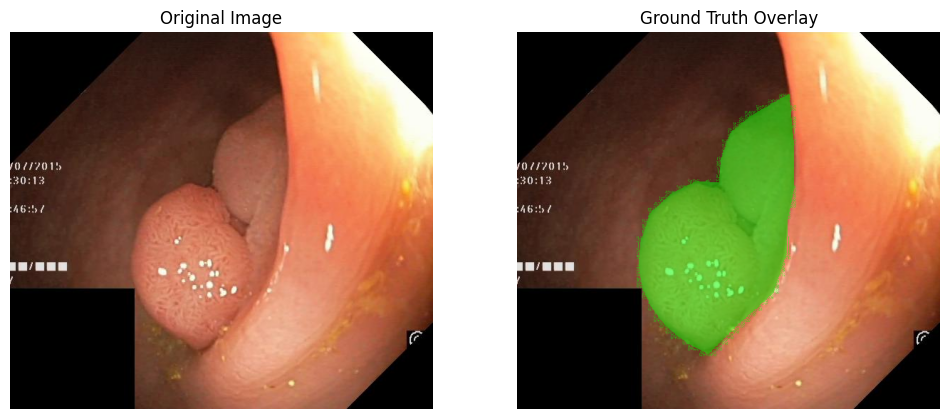

In [4]:
fileName = fileNames[900]

image_path = f"kvasir-seg/Kvasir-SEG/images/{fileName}.jpg"
mask_path = f"kvasir-seg/Kvasir-SEG/masks/{fileName}.jpg"

image = Image.open(image_path).convert("RGBA")

mask = Image.open(mask_path).convert("L")

overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))

mask_np = np.array(mask)

overlay_color = (0, 255, 0, 128)

overlay_np = np.array(overlay)
overlay_np[mask_np > 0] = overlay_color
overlay = Image.fromarray(overlay_np)


ground_truth_image = Image.alpha_composite(image, overlay)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(ground_truth_image)
ax[1].set_title("Ground Truth Overlay")
ax[1].axis('off')

plt.show()

## Cell 5: Splitting the Dataset

This cell splits the list of filenames into three distinct subsets: **training (70%)**, **validation (15%)**, and **testing (15%)**.

It uses the `train_test_split` function from scikit-learn in a two-step process. First, the data is split into a 70% training set and a 30% temporary set. The temporary set is then split in half to create the final validation and test sets. This division is essential for training, tuning, and evaluating the model on completely unseen data.

In [5]:
trainSet, Temp = train_test_split(fileNames, test_size=0.3, random_state=42)
testSet, valSet = train_test_split(Temp, test_size=0.5, random_state=42)

## Cell 6: Preparing the Data Pipeline

This cell sets up the entire data loading and preprocessing pipeline. It defines how images and masks are loaded from disk, augmented, and prepared for the model.

* **`KvasirDataset` Class**: This custom PyTorch **`Dataset`** defines the logic for loading a single image-mask pair and applying transformations.
* **Augmentation Pipelines**: Two separate pipelines are created using **`albumentations`**. The **`train_transform`** includes aggressive data augmentation (flips, rotations, distortions) to help the model generalize. The **`test_transform`** only contains the essential preprocessing for consistent evaluation.
* **`DataLoaders`**: The final step creates `Dataset` instances for each data split and wraps them in `DataLoader`s, which handle batching and shuffling the data efficiently for the model.

In [6]:
class KvasirDataset(Dataset):
    def __init__(self, imageDir, maskDir, fileNames, transform):
        self.imageDir = imageDir
        self.maskDir = maskDir
        self.transform = transform
        self.fileNames = fileNames
        
    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        imagePath = f"{self.imageDir}/{self.fileNames[idx]}.jpg"
        maskPath = f"{self.maskDir}/{self.fileNames[idx]}.jpg"
        image = np.array(Image.open(imagePath).convert("RGB"))
        mask = np.array(Image.open(maskPath).convert("L"))
        mask = mask / 255.0
        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return image, mask

train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=1.0),
    A.ElasticTransform(p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

IMAGES_PATH = "kvasir-seg/Kvasir-SEG/images"
MASKS_PATH = "kvasir-seg/Kvasir-SEG/masks"

train_dataset = KvasirDataset(IMAGES_PATH, MASKS_PATH, trainSet, train_transform)
val_dataset = KvasirDataset(IMAGES_PATH, MASKS_PATH, valSet, test_transform)
test_dataset = KvasirDataset(IMAGES_PATH, MASKS_PATH, testSet, test_transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8164\4084692042.py:29: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),


## Cell 7: Model Definition and Summary

This cell defines the **U-Net++** deep learning model, configures it for the available hardware, and prints a detailed architectural summary.

* **Model Definition**: It creates a `UnetPlusPlus` model using a powerful, pre-trained `efficientnet-b3` backbone. This leverages transfer learning to speed up training. *Note: The `dropout` parameter here should likely be `decoder_dropout=0.4` to correctly add dropout to the decoder blocks.*
* **Device Configuration**: The code detects if a GPU (`cuda`) is available for accelerated training and moves the model to the appropriate device.
* **Architecture Summary**: Finally, `torchinfo.summary()` is used to display a layer-by-layer breakdown of the model, confirming its structure and parameter count.

In [7]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    dropout=0.4
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = model.to(device)

input_size = (16, 3, 256, 256)

torchinfo.summary(model, input_size=input_size)

Using cuda device


Layer (type:depth-idx)                                  Output Shape              Param #
UnetPlusPlus                                            [16, 1, 256, 256]         --
├─EfficientNetEncoder: 1-1                              [16, 3, 256, 256]         592,896
│    └─Conv2dStaticSamePadding: 2-1                     [16, 40, 128, 128]        1,080
│    │    └─ZeroPad2d: 3-1                              [16, 3, 257, 257]         --
│    └─BatchNorm2d: 2-2                                 [16, 40, 128, 128]        80
│    └─SiLU: 2-3                                        [16, 40, 128, 128]        --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [16, 24, 128, 128]        2,298
│    │    └─MBConvBlock: 3-3                            [16, 24, 128, 128]        1,206
│    │    └─MBConvBlock: 3-4                            [16, 32, 64, 64]          11,878
│    │    └─MBConvBlock: 3-5              

## Cell 8: Training Configuration

This cell sets up the core components for the training loop: the loss function, optimizer, and learning rate scheduler.

* **Loss Function**: A **`combined_loss`** is created by adding **`BCEWithLogitsLoss`** (for pixel-level error) and **`DiceLoss`** (for shape overlap). This provides a robust measure of the model's performance.
* **Optimizer**: The **`Adam`** optimizer is chosen to update the model's weights. It's a standard and highly effective choice for deep learning tasks.
* **Scheduler**: A **`CosineAnnealingLR`** is configured to dynamically adjust the learning rate during training, which helps improve convergence and final performance.

In [8]:
loss_dice = smp.losses.DiceLoss(mode='binary')
loss_bce = nn.BCEWithLogitsLoss()
def combined_loss(prediction, target):
    return loss_bce(prediction, target) + loss_dice(prediction, target)
NUM_EPOCHS = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

## Cell 9: The Training Engine

This cell contains the complete engine for training and evaluating the model. It defines three key functions that work together to orchestrate the learning process.

* **`train_one_epoch`**: This function handles a single pass through the entire training dataset. For each batch, it performs the five core steps of learning (forward pass, loss calculation, backpropagation, etc.) and calculates the average loss and Dice score for the epoch.
* **`validate_one_epoch`**: This function evaluates the model's performance on the validation set. It is similar to the training function but crucially skips gradient calculations and weight updates to get an unbiased performance metric.
* **`train`**: This is the main controller function that loops for a set number of epochs. In each loop, it calls the training and validation functions, records the results, updates the learning rate scheduler, and saves the best-performing model to a file (`best_model.pth`).

In [9]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):

    model.train()
    total_loss = 0.0
    total_dice_score = 0.0
    
    for batch in tqdm(loader):
        # Here is where our 5 core steps will go
        # 1. Forward pass
        images, true_masks = batch

        images = images.to(device)

        true_masks = true_masks.to(device).unsqueeze(1).float()
        predictions = model(images)
        
        # 2. Calculate Loss and dice_score
        loss = loss_fn(predictions, true_masks)
        total_loss += loss.item()

        preds_prob = torch.sigmoid(predictions)
        preds_binary = (preds_prob > 0.5).float()
            
        dice_score = (2. * (preds_binary * true_masks).sum()) / (preds_binary.sum() + true_masks.sum() + 1e-8)
        total_dice_score += dice_score.item()
        
        # 3. Zero Gradients
        optimizer.zero_grad()
        
        # 4. Backward Pass
        loss.backward()
        
        # 5. Update Weights
        optimizer.step()
        pass
        
    avg_loss = total_loss / len(loader)
    avg_dice = total_dice_score / len(loader)
    
    return avg_loss, avg_dice

def validate_one_epoch(loader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_dice_score = 0.0
    
    with torch.no_grad():
        for batch in tqdm(loader):
            images, true_masks = batch
            images = images.to(device)
            true_masks = true_masks.to(device).unsqueeze(1).float()

            predictions = model(images)
            
            loss = loss_fn(predictions, true_masks)
            total_loss += loss.item()
            

            preds_prob = torch.sigmoid(predictions)
            preds_binary = (preds_prob > 0.5).float()
            
            dice_score = (2. * (preds_binary * true_masks).sum()) / (preds_binary.sum() + true_masks.sum() + 1e-8)
            total_dice_score += dice_score.item()
            
    avg_loss = total_loss / len(loader)
    avg_dice = total_dice_score / len(loader)
    
    return avg_loss, avg_dice


def train(train_loader, val_loader, model, optimizer, scheduler, loss_fn, NUM_EPOCHS, device):

    best_val_dice = 0.0
    train_history = {'loss': [], 'dice': []}
    val_history = {'loss': [], 'dice': []}
    best_model_state = None

    
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        train_loss, train_dice = train_one_epoch(train_loader, model, optimizer, loss_fn, device)
        print(f"Train -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        # Run one validation epoch
        val_loss, val_dice = validate_one_epoch(val_loader, model, loss_fn, device)
        print(f"Val   -> Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")
        
        # Save history
        train_history['loss'].append(train_loss)
        train_history['dice'].append(train_dice)
        val_history['loss'].append(val_loss)
        val_history['dice'].append(val_dice)
        
        # Save the best model
        if val_dice > best_val_dice:
            print(f"Validation Dice improved! Saving model...")
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pth')
            best_model_state = model.state_dict()
        # Update the learning rate scheduler
        scheduler.step()

    print("--- Training Complete ---")
    return best_model_state, train_history, val_history

## Cell 10: Executing the Training

This cell calls the main `train` function to start the model's training and validation process.

It passes all the previously defined components—**data loaders**, the **model**, **optimizer**, **scheduler**, and **loss function**—into the training engine. The training will run for the specified `NUM_EPOCHS`. Upon completion, it returns and stores the **weights of the best model** and the **full training and validation histories** for later analysis.

In [10]:
model_state, train_history, val_history = train(train_loader, val_loader, model, optimizer, scheduler, combined_loss, NUM_EPOCHS, device)

--- Epoch 1/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:55<00:00,  2.62s/it]


Train -> Loss: 0.8427, Dice: 0.6796


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


Val   -> Loss: 0.5341, Dice: 0.7857
Validation Dice improved! Saving model...
--- Epoch 2/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [02:02<00:00,  2.78s/it]


Train -> Loss: 0.4095, Dice: 0.8223


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


Val   -> Loss: 0.4911, Dice: 0.7687
--- Epoch 3/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:51<00:00,  2.53s/it]


Train -> Loss: 0.3488, Dice: 0.8406


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


Val   -> Loss: 0.3915, Dice: 0.8171
Validation Dice improved! Saving model...
--- Epoch 4/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:53<00:00,  2.57s/it]


Train -> Loss: 0.3069, Dice: 0.8578


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]


Val   -> Loss: 0.4095, Dice: 0.8153
--- Epoch 5/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:58<00:00,  2.69s/it]


Train -> Loss: 0.2703, Dice: 0.8743


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]


Val   -> Loss: 0.3686, Dice: 0.8320
Validation Dice improved! Saving model...
--- Epoch 6/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:54<00:00,  2.61s/it]


Train -> Loss: 0.2384, Dice: 0.8910


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]


Val   -> Loss: 0.3092, Dice: 0.8549
Validation Dice improved! Saving model...
--- Epoch 7/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.2244, Dice: 0.8954


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.24it/s]


Val   -> Loss: 0.3030, Dice: 0.8608
Validation Dice improved! Saving model...
--- Epoch 8/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.2222, Dice: 0.8951


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.94it/s]


Val   -> Loss: 0.3018, Dice: 0.8596
--- Epoch 9/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.50s/it]


Train -> Loss: 0.2057, Dice: 0.9030


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Val   -> Loss: 0.2647, Dice: 0.8773
Validation Dice improved! Saving model...
--- Epoch 10/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.2012, Dice: 0.9077


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s]


Val   -> Loss: 0.3209, Dice: 0.8511
--- Epoch 11/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.50s/it]


Train -> Loss: 0.1804, Dice: 0.9158


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.03it/s]


Val   -> Loss: 0.2592, Dice: 0.8775
Validation Dice improved! Saving model...
--- Epoch 12/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.48s/it]


Train -> Loss: 0.1750, Dice: 0.9182


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.75it/s]


Val   -> Loss: 0.2548, Dice: 0.8847
Validation Dice improved! Saving model...
--- Epoch 13/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:48<00:00,  2.47s/it]


Train -> Loss: 0.1640, Dice: 0.9230


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.48it/s]


Val   -> Loss: 0.2450, Dice: 0.8826
--- Epoch 14/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.1479, Dice: 0.9301


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


Val   -> Loss: 0.2288, Dice: 0.8924
Validation Dice improved! Saving model...
--- Epoch 15/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:48<00:00,  2.47s/it]


Train -> Loss: 0.1591, Dice: 0.9245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Val   -> Loss: 0.2489, Dice: 0.8830
--- Epoch 16/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:51<00:00,  2.53s/it]


Train -> Loss: 0.1444, Dice: 0.9325


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.50it/s]


Val   -> Loss: 0.2504, Dice: 0.8901
--- Epoch 17/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:50<00:00,  2.51s/it]


Train -> Loss: 0.1339, Dice: 0.9363


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.95it/s]


Val   -> Loss: 0.2808, Dice: 0.8746
--- Epoch 18/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:50<00:00,  2.51s/it]


Train -> Loss: 0.1193, Dice: 0.9434


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]


Val   -> Loss: 0.2398, Dice: 0.8893
--- Epoch 19/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.50s/it]


Train -> Loss: 0.1167, Dice: 0.9442


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.04it/s]


Val   -> Loss: 0.2805, Dice: 0.8783
--- Epoch 20/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.50s/it]


Train -> Loss: 0.1178, Dice: 0.9447


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]


Val   -> Loss: 0.2762, Dice: 0.8836
--- Epoch 21/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.1068, Dice: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Val   -> Loss: 0.2469, Dice: 0.8924
--- Epoch 22/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.49s/it]


Train -> Loss: 0.1076, Dice: 0.9485


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Val   -> Loss: 0.2424, Dice: 0.8936
Validation Dice improved! Saving model...
--- Epoch 23/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:51<00:00,  2.53s/it]


Train -> Loss: 0.1038, Dice: 0.9503


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]


Val   -> Loss: 0.2638, Dice: 0.8852
--- Epoch 24/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:48<00:00,  2.48s/it]


Train -> Loss: 0.0975, Dice: 0.9529


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Val   -> Loss: 0.2463, Dice: 0.8943
Validation Dice improved! Saving model...
--- Epoch 25/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:48<00:00,  2.48s/it]


Train -> Loss: 0.0997, Dice: 0.9523


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.43it/s]


Val   -> Loss: 0.2302, Dice: 0.9006
Validation Dice improved! Saving model...
--- Epoch 26/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:50<00:00,  2.51s/it]


Train -> Loss: 0.0983, Dice: 0.9523


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


Val   -> Loss: 0.2251, Dice: 0.9021
Validation Dice improved! Saving model...
--- Epoch 27/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:49<00:00,  2.50s/it]


Train -> Loss: 0.0954, Dice: 0.9548


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


Val   -> Loss: 0.2271, Dice: 0.9020
--- Epoch 28/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:51<00:00,  2.52s/it]


Train -> Loss: 0.0945, Dice: 0.9545


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.26it/s]


Val   -> Loss: 0.2277, Dice: 0.9020
--- Epoch 29/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:50<00:00,  2.51s/it]


Train -> Loss: 0.0908, Dice: 0.9564


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.23it/s]


Val   -> Loss: 0.2295, Dice: 0.9011
--- Epoch 30/30 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:50<00:00,  2.51s/it]


Train -> Loss: 0.0918, Dice: 0.9561


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.67it/s]

Val   -> Loss: 0.2264, Dice: 0.9024
Validation Dice improved! Saving model...
--- Training Complete ---


## Cell 11: Plotting Training History

This cell uses **`matplotlib`** to visualize the model's performance throughout the training process.

It generates two side-by-side plots using the `train_history` and `val_history` dictionaries:
1.  **Loss vs. Epochs**: A line chart showing the decrease in both training and validation loss over time. This is key for diagnosing issues like overfitting.
2.  **Dice Score vs. Epochs**: A line chart showing the improvement in the Dice score for both training and validation sets, illustrating how the model's accuracy evolved.

These charts provide a crucial visual summary of the entire training session.

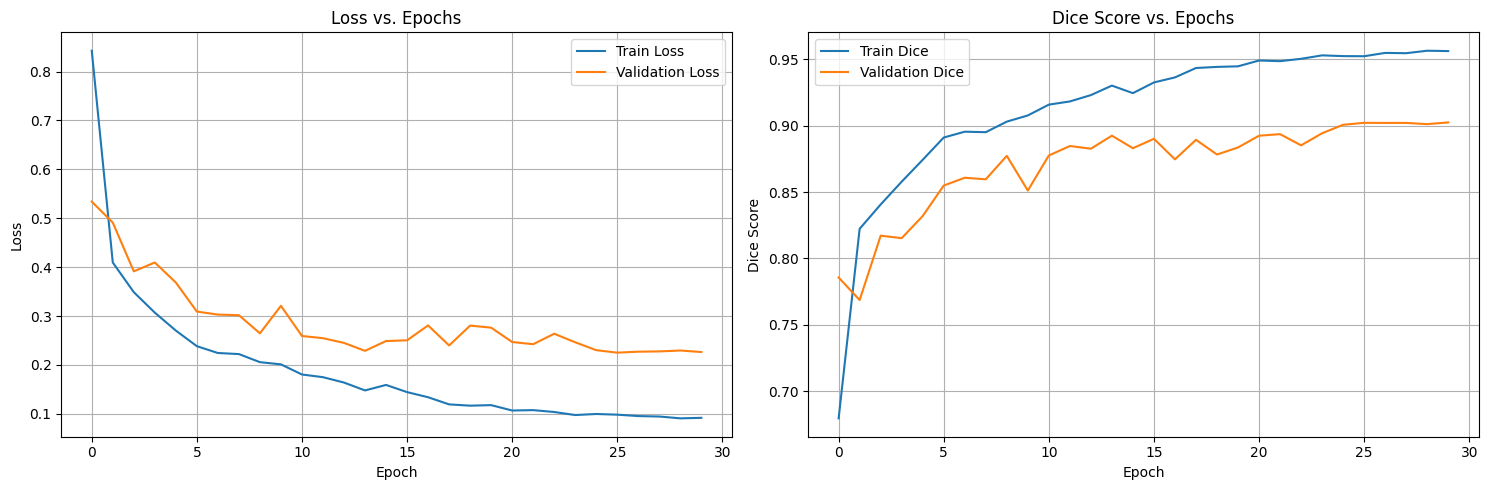

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Loss vs. Epochs ---
ax[0].plot(train_history['loss'], label='Train Loss')
ax[0].plot(val_history['loss'], label='Validation Loss')
ax[0].set_title('Loss vs. Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# --- Plot 2: Dice Score vs. Epochs ---
ax[1].plot(train_history['dice'], label='Train Dice')
ax[1].plot(val_history['dice'], label='Validation Dice')
ax[1].set_title('Dice Score vs. Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Score')
ax[1].legend()
ax[1].grid(True)

# --- Display the plots ---
plt.tight_layout()
plt.show()

## Cell 12: Test Function Definition

This cell defines the `test` function, which evaluates the final performance of the trained model on the unseen test dataset.

The function operates in evaluation mode (**`model.eval()`** and **`torch.no_grad()`**), so it does not update the model's weights. It iterates through the `test_loader`, calculates the average loss and Dice score across all the test data, and returns these final performance metrics. This provides the ultimate, unbiased measure of the model's success.

In [12]:
def test(loader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_dice_score = 0.0
    
    with torch.no_grad():
        for batch in tqdm(loader):
            images, true_masks = batch
            images = images.to(device)
            true_masks = true_masks.to(device).unsqueeze(1).float()

            predictions = model(images)
            
            loss = loss_fn(predictions, true_masks)
            total_loss += loss.item()
            

            preds_prob = torch.sigmoid(predictions)
            preds_binary = (preds_prob > 0.5).float()
            
            dice_score = (2. * (preds_binary * true_masks).sum()) / (preds_binary.sum() + true_masks.sum() + 1e-8)
            total_dice_score += dice_score.item()
            
    avg_loss = total_loss / len(loader)
    avg_dice = total_dice_score / len(loader)
    
    return avg_loss, avg_dice

## Cell 13: Final Model Evaluation

This cell performs the final evaluation of the trained model on the held-out test set.

It first creates an instance of the model architecture and loads the best-performing weights that were saved during training from the `best_model.pth` file. It then calls the `test` function to run this model on the test data.

Finally, it prints the definitive **Test Loss** and **Test Dice Score**, which represent the model's final, unbiased performance on completely unseen data.

In [13]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    in_channels=3,
    classes=1,
)
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.to(device)

test_loss, test_dice = test(test_loader, model, combined_loss, device)

print("\n--- Test Results ---")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Dice Score: {test_dice:.2f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.46it/s]


--- Test Results ---
Test Loss: 0.16
Test Dice Score: 0.92


## Cell 14: Creating the Test Set Iterator

This cell creates an **iterator** from the `test_loader`.

An iterator is an object that allows you to go through a sequence one item at a time. This is a setup step for the next cell, enabling it to load a new, different batch of test images each time it's run.

In [16]:
testIterator = iter(test_loader)

## Cell 15: Visualizing Test Predictions

This cell provides a qualitative assessment of the model's performance by visualizing its predictions on a batch of test images.

It **loads** the next batch of data from the `testIterator`, **generates** predictions from the model, and then **plots** a side-by-side comparison for three examples. For each example, it displays the original image, the ground truth mask (green overlay), and the model's predicted mask (red overlay), along with the calculated Dice score. This allows for a direct visual inspection of the model's accuracy on specific images.

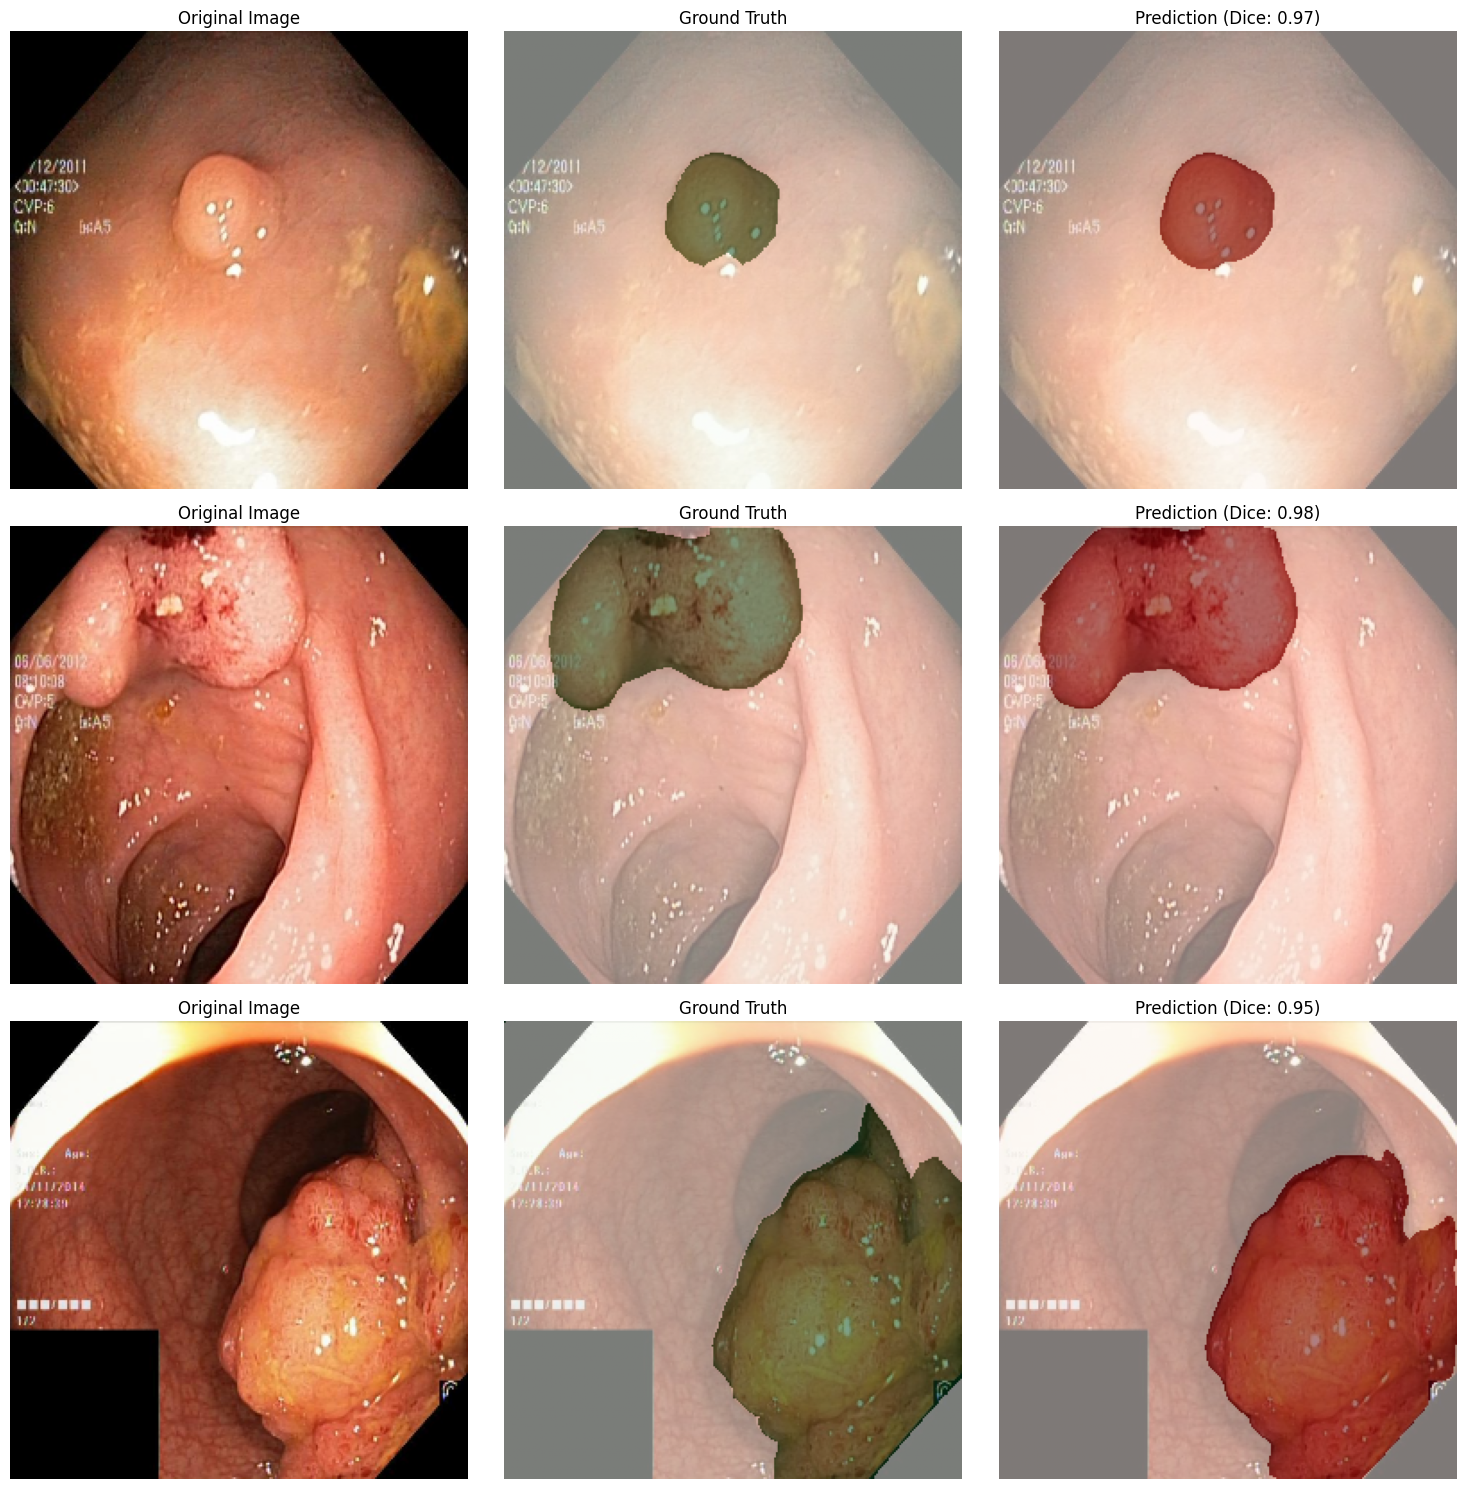

In [18]:
images, true_masks = next(testIterator)
images = images.to(device)
true_masks = true_masks.to(device)

model.eval()
with torch.no_grad():
    predictions = model(images)

probabilities = F.sigmoid(predictions)
predicted_masks = (probabilities > 0.5).float()

num_examples = 3
fig, ax = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))

for i in range(num_examples):
    # --- Prepare Data for Plotting ---
    img = images[i]
    true_mask = true_masks[i]
    pred_mask = predicted_masks[i]

    # Calculate Dice score for this single example
    dice_score = (2. * (pred_mask * true_mask).sum()) / (pred_mask.sum() + true_mask.sum() + 1e-8)
    
    # Move to CPU and convert to NumPy for plotting/PIL
    img_np = img.permute(1, 2, 0).cpu().numpy()
    true_mask_np = true_mask.squeeze().cpu().numpy()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    
    # Un-normalize the image for viewing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    ax[i, 0].imshow(img_np)
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis('off')

    ax[i, 1].imshow(img_np)
    ax[i, 1].imshow(true_mask_np, cmap='Greens', alpha=0.5)
    ax[i, 1].set_title("Ground Truth")
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(img_np)
    ax[i, 2].imshow(pred_mask_np, cmap='Reds', alpha=0.5)
    ax[i, 2].set_title(f"Prediction (Dice: {dice_score:.2f})")
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()